# load packages

/global/home/users/amandapaulson/.conda/envs/atomsci/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/global/home/users/amandapaulson/.conda/envs/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
DEBUG:ATOM:Model tracker client not supporte

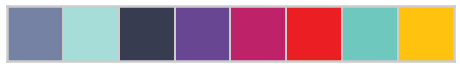

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path

sns.set_context("poster")
sns.set_style("whitegrid")

import pandas as pd
from pandas.api.types import CategoricalDtype


from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import diversity_plots as dp

pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns', 90)

# Create an array with the colors you want to use
colors = ["#7682A4","#A7DDD8","#373C50","#694691","#BE2369","#EB1E23","#6EC8BE","#FFC30F",]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
sns.palplot(pal)

%config Completer.use_jedi = False

# load data and examine

In [2]:
shortlist_key = "/global/home/users/amandapaulson/data/bsep_feat_shortlist_with_uuids.csv"

In [3]:
df = pd.read_csv(shortlist_key, index_col=False)
# get rid of active in response cols since we're making regression models
df.response_cols=df.response_cols.str.replace(',active','')
df['model_type']=['classification','regression','classification','regression']
df

,dataset_key,bucket,response_cols,collection,random_10_10,random_15_15,random_10_20,random_20_20,scaffold_10_10,scaffold_15_15,scaffold_10_20,scaffold_20_20,fingerprint_10_10,fingerprint_15_15,fingerprint_10_20,fingerprint_20_20,model_type
0,/global/home/users/amandapaulson/data/curated_...,public,substrate,BSEP_substrate_class,9b4c1491-27d8-460b-8531-fdf88ebab3a9,dd241db5-8735-4249-98ee-febbe5b3590f,ea5505cf-05ab-4b99-95a0-c9c39eb895b5,5925ea42-3ac0-4d06-b01d-ba857f7fd4e3,NaN,NaN,NaN,NaN,f87dc56c-6615-49d8-b41a-d2a82fe2d5c9,55a1d301-d2c0-45d1-a9c4-8a136a66268f,1176149d-2c84-49de-8c9b-6f7a0f469d08,c2d89b38-97ba-43ab-a7b5-6115b214bf33,classification
1,/global/home/users/amandapaulson/data/curated_...,public,pIC50,BSEP_pIC50_reg,a3957fff-9857-49f2-b596-2e50bef64f61,d371b7c7-8705-4057-beec-3a42a6f6196f,97c576a7-9d95-45a7-94bb-2eb82ccc64d2,1675990e-e55b-48e8-9227-c2db8dd3497e,26021005-0cd6-4ee6-872f-e2a036fe0981,754a5b73-fcca-4b0a-a823-80f2717ba6fd,9a8c9002-888d-49a4-9eb6-6c517c165eb2,55574502-4524-4b39-acb8-5d41eab8a25c,0fde29ef-f8e1-4c81-9135-4166fcb77129,374c75f0-04ff-4ace-97a6-37ba3ff0774e,8efc2521-830e-47fa-8c60-ed528b76f9a1,315c00fe-4fb4-4095-adc3-7f86ce3345e6,regression
2,/global/home/users/amandapaulson/data/curated_...,public,inhibitor,BSEP_inhibitor_class,61b485b9-ceff-4742-b3d7-b02d72ba0f74,7624990e-0093-4653-967a-e88fa147eb13,b9da9cf9-e2de-443d-91a9-d122e439bf15,90da2246-be18-407b-83a7-2737e3beb9cf,31934b3e-0f25-4bda-b639-55472648a36c,9c147930-65e8-4e1c-ba26-09a44fd77d31,b2c48656-7143-4c51-aeb7-9b41f540ea77,6a6ccbfa-e69d-43fb-bf4c-5ae74099d48e,14b7bf3a-6272-43e0-8e9d-c6e385a14e41,262113db-910f-42d2-abc8-28d5a5beb318,57fade82-dd21-45f8-a5b8-9ed3d5d2112a,b75234da-dd2c-458b-8e1f-98b688046403,classification
3,/global/home/users/amandapaulson/data/curated_...,public,pct_inhib,BSEP_pct_inhib_reg,596df618-5760-43ac-9b40-332dee64f2be,8e47bf5f-8fdb-47e2-aefd-eb373de5a961,da2a26e5-185f-41f4-9cf9-2c952c91efd0,3fc09959-10fb-4888-8373-a370d75f59bd,62b2c43a-213d-4f40-959c-dc24767f2bc2,d5e21e98-0b7b-4a6e-a454-d64eafffd600,7c754b0c-49e9-4905-ab3b-b5e2183b875b,b1c877af-0a06-4f2c-9215-ef576cdbb410,301908ba-2a8b-4fe4-9f2e-2a8a72c2d252,6f84fe3f-287e-463b-b204-26d6dcbfeb3c,0cb8ae0b-335f-4dc6-abc6-bc5d134e77a2,89f8ab28-ae70-4892-9977-b93cbd42dc8f,regression


# Perform EDA on dataset splits

In [4]:
import importlib
importlib.reload(dp)

<module 'atomsci.ddm.pipeline.diversity_plots' from '/global/home/users/amandapaulson/repos/AMPL/atomsci/ddm/pipeline/diversity_plots.py'>

/global/home/users/amandapaulson/data/curated_datasets/combined_ic50_inhibitor_data_cur.csv
Duplicate SMILES: 0 	Duplicate compound IDs: 0 	Duplicate indices: 0 	NA SMILES: 0 	NA meas: 0
Shape: (1099, 5) 

/global/home/users/amandapaulson/data/curated_datasets/combined_class_inhibitor_data_cur.csv
Duplicate SMILES: 0 	Duplicate compound IDs: 0 	Duplicate indices: 0 	NA SMILES: 0 	NA meas: 0
Shape: (1189, 4) 



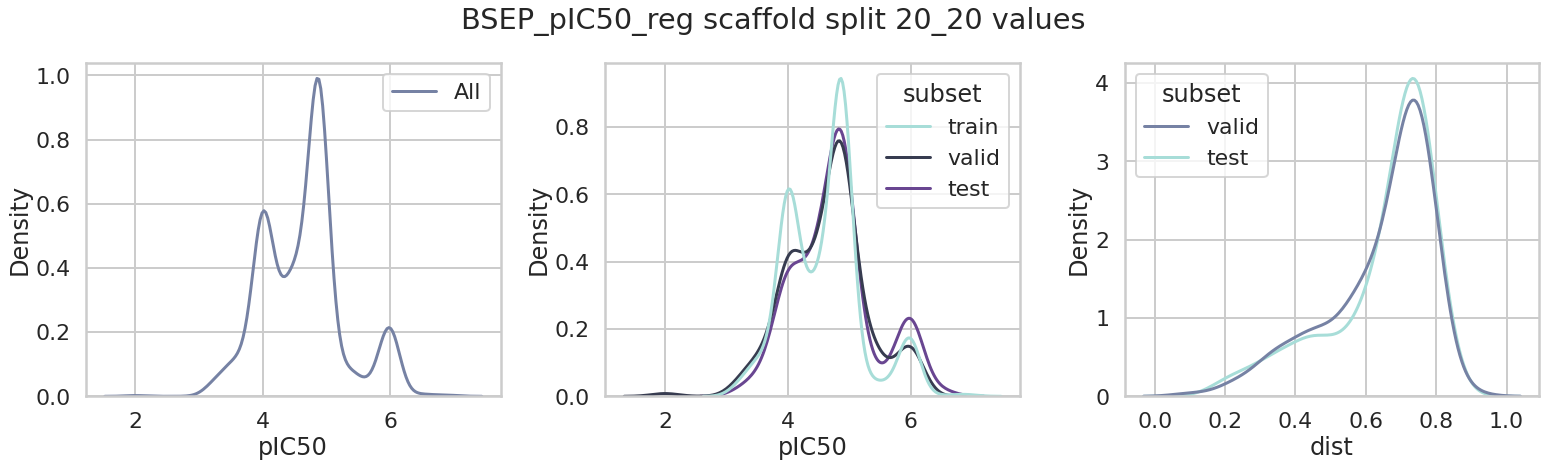

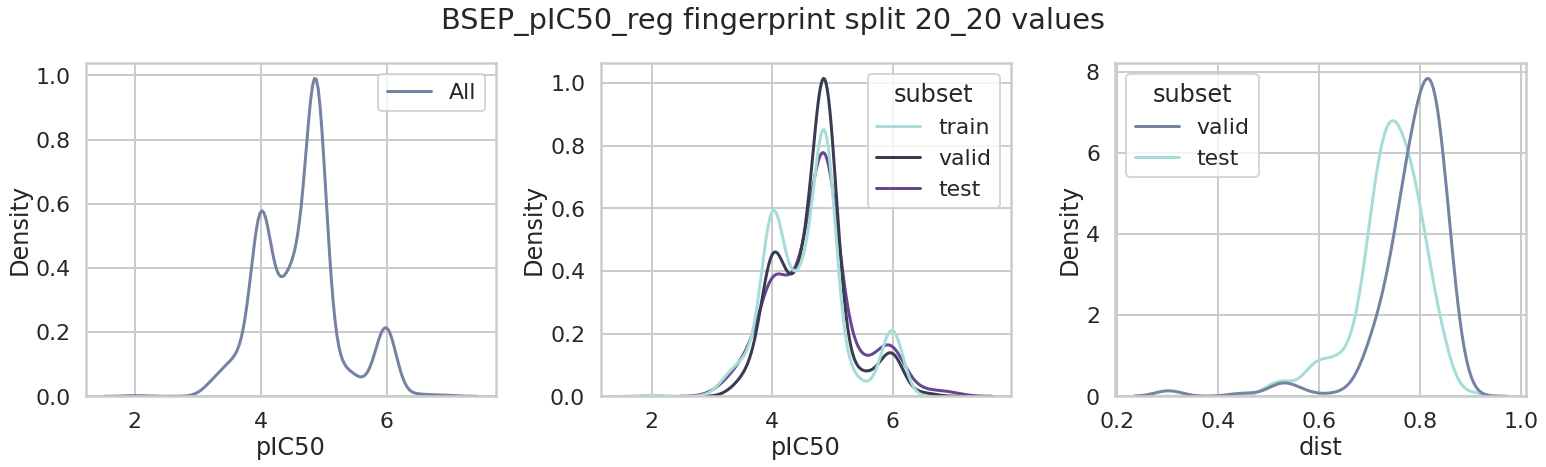

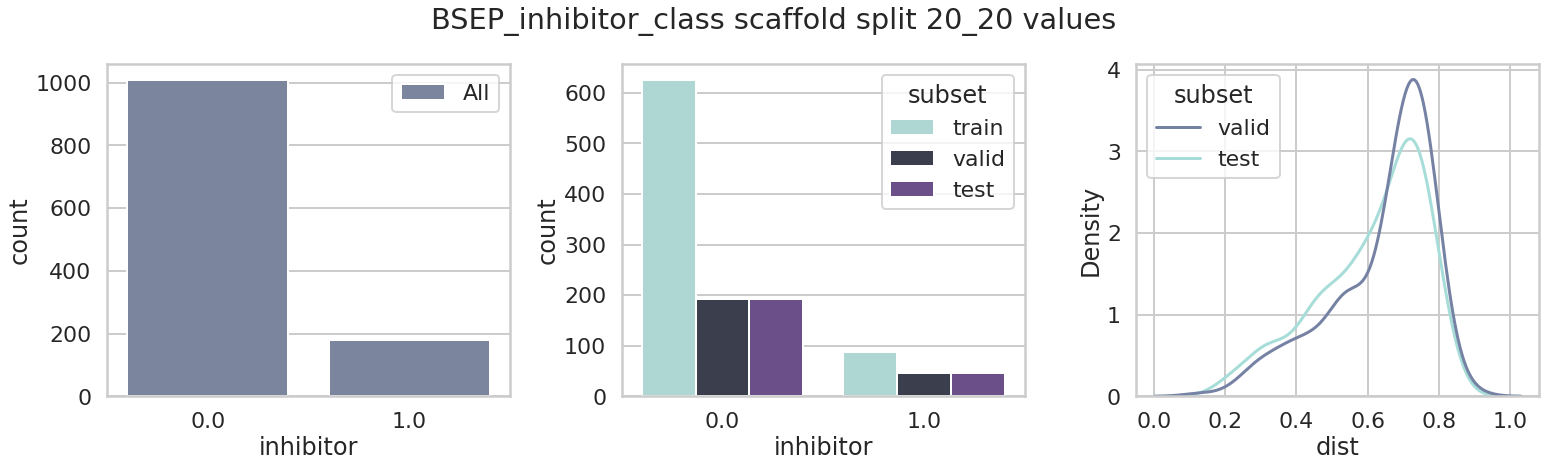

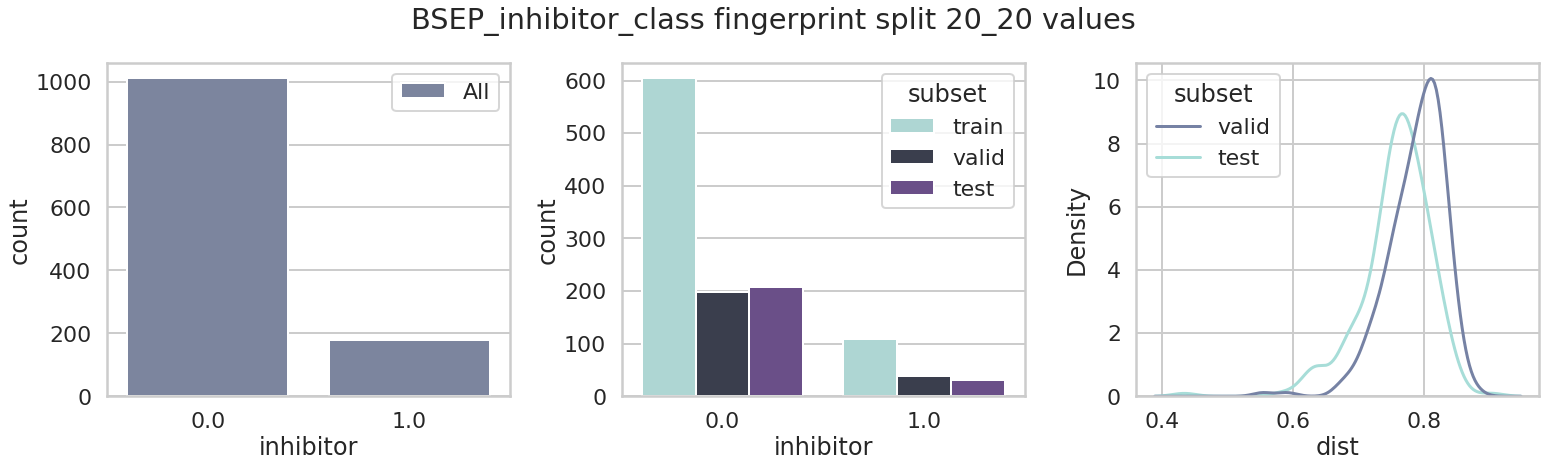

In [5]:
sns.set_context('poster')
for i,row in df.iterrows():
    
    #####################################
    # for demonstration only, don't include this in yours
    if (i==0 or i==3):
        continue
    #####################################
    
    dataset_key=row.dataset_key
    print(dataset_key)
    txptr=dataset_key.split('/')[-1][0:9]
    resp=row.response_cols
    data=pd.read_csv(dataset_key)
    model_type=row.model_type
    coll=row.collection
    subcat = CategoricalDtype(categories=['train','valid','test'], ordered=True)
    print("Duplicate SMILES:",data.duplicated(subset="base_rdkit_smiles").sum(), "\tDuplicate compound IDs:",data.duplicated(subset="compound_id").sum(), "\tDuplicate indices:",data.index.duplicated().sum(), "\tNA SMILES:",data.base_rdkit_smiles.isna().sum(), "\tNA meas:", data[resp].isna().sum())
    print("Shape:", data.shape, '\n')
    
    for splitter in ['scaffold','fingerprint']:
        for frac in ['20_20']:#, '15_15','20_20']:
            data=pd.read_csv(dataset_key)
            split_path=dataset_key.replace('.csv',f"_train_valid_test_{splitter}_{row[f'{splitter}_{frac}']}.csv")
            if '_nan.csv' in split_path:
                continue
            split=pd.read_csv(split_path)
            data=data.merge(split, left_on='compound_id', right_on='cmpd_id')
            data.subset = data.subset.astype(subcat)
            data = data.sort_values('subset', ascending=True)

            fig, ax = plt.subplots(1,3, figsize = (22,7))
            if model_type=='regression':
                sns.kdeplot(data[resp], color=pal[0], label='All', common_norm=False, ax=ax[0])
                ax[0].legend()
                sns.kdeplot(data[resp],hue=data['subset'], palette=pal[1:4], common_norm=False, ax=ax[1])
            else:
                sns.countplot(x=data[resp], color=pal[0], label='All', ax=ax[0])
                ax[0].legend()
                sns.countplot(x=data[resp],hue=data['subset'],palette=pal[1:4],ax=ax[1])
            dists =dp.plot_tani_dist_distr(data, 'base_rdkit_smiles', lab='', subsets=True, plot_width=10, subset_col='subset', ax=ax[2], df_name=txptr)
            fig.suptitle(f'{coll} {splitter} split {frac} values', y=0.95)
            fig.tight_layout();

In [6]:
data.head(2)

,compound_id,base_rdkit_smiles,relation,inhibitor,cmpd_id,subset,fold
0,1-methyl-4- phenylpyridinium,C[n+]1ccc(-c2ccccc2)cc1,NaN,0.0,1-methyl-4- phenylpyridinium,train,0
701,CHEMBL4087891,C[C@H](CC(=O)Nc1c(Cl)ccc2nc(N3CC[C@H](N)C3)ccc...,NaN,1.0,CHEMBL4087891,train,0


# Create parameter json

Parameter options here: https://github.com/ATOMconsortium/AMPL/blob/master/atomsci/ddm/docs/PARAMETERS.md

## IMPORTANT: YOUR RESULT DIR CANNOT BE YOUR HOME DIR

In [7]:
result_dir="/global/scratch/users/amandapaulson/hyperparam_test_1"

In [8]:
shortlist_key

'/global/home/users/amandapaulson/data/bsep_feat_shortlist_with_uuids.csv'

In [9]:
# make regression-only shortlist
shortlist_key=shortlist_key.replace('.csv','_reg.csv')
shortlist_key

'/global/home/users/amandapaulson/data/bsep_feat_shortlist_with_uuids_reg.csv'

In [10]:
df[df.model_type=='regression'].to_csv(shortlist_key)
shortlist_key

'/global/home/users/amandapaulson/data/bsep_feat_shortlist_with_uuids_reg.csv'

In [22]:
params = {
    # don't change these
    "hyperparam": "True",
    "slurm_account": "ic_engin296ma",
    "slurm_partition": "savio2_htc",
    "slurm_time_limit": "60",
    "slurm_nodes":"None",
    "slurm_options":"#SBATCH@--cpus-per-task=1",
    "system": "LC",
    "datastore": "False",
    "max_jobs":"10",
    
    # these will be modified depending on what you need to do
    
    # splitting params
    "split_only": "False",
    "previously_split":"True",
    "use_shortlist": "True",
    "shortlist_key": shortlist_key,
    "result_dir": result_dir,
    "smiles_col" : "base_rdkit_smiles",

    # featurization & training params
    "search_type":"user_specified",
    "prediction_type": "regression",
    "transformers": "True",
    "featurizer": "ecfp,graphconv,computed_descriptors",
    "descriptor_type": "rdkit_raw,mordred_filtered", # for featurizer = computed descriptors
    "model_type": "RF,NN,xgboost",
    
    #ecfp specific
    "ecfp_radius":"2", # 2-6
    
    # rf specific
    "rf_estimators": "10,15,20,25,50,100,200,400,800",#"10,15,20,25,30,40,50,60,70,80,90,100,110,120,150,200,300,400,500",#
    "rf_max_depth": "5,10,15,20,50,100",#"5,10,15,20,25,40,60,80,100,120",
    "rf_max_features": "16,20,24,28,32,64",#"16,18,20,22,24,26,28,30,32",

    # nn specific
    'max_epochs': '300', # lowest rec: 100
    "learning_rate": ".00001,.00005,.0001,.0005,.001,.005,.01,.025,.05",
    "layer_sizes": "64,16 64,16 64,16 64,16 128,32 128,32 128,32 128,32 256,64 256,64 256,64 256,64 512,128 512,128 512,128 512,128 256,64,16 256,64,16 256,64,16 256,64,16",
    "dropouts": "0.1,0.1 0.2,0.2 0.3,0.3 0.4,0.4 0.1,0.1 0.2,0.2 0.3,0.3 0.4,0.4 0.1,0.1 0.2,0.2 0.3,0.3 0.4,0.4 0.1,0.1 0.2,0.2 0.3,0.3 0.4,0.4 0.1,0.1,0.1 0.2,0.2,0.2 0.3,0.3,0.3 0.4,0.4,0.4",
    
    # xgboost specific
    "xgb_gamma": '0.0,0.05,0.1,0.2,0.3,0.4,0.5',
    "xgb_learning_rate": '1,0.5,0.25,0.2,0.15,0.10,0.05,0.01,0.001,0.0001',
}

In [23]:
import json

In [24]:
fname=f'{result_dir}/Regression_HPSearch_Shortlist.json'
with open(fname, 'w') as fp:
    json.dump(params, fp, indent=4)

print(f'python ~/repos/AMPL/atomsci/ddm/utils/hyperparam_search_wrapper.py --config_file {fname}')

python ~/repos/AMPL/atomsci/ddm/utils/hyperparam_search_wrapper.py --config_file /global/scratch/users/amandapaulson/hyperparam_test_1/Regression_HPSearch_Shortlist.json


# Train models

- use `tmux` so if you disconnect from ssh it doesn't kill the jobs
- run the following from an environment with AMPL installation:

`$ cd ~`

`$ ulimit -n 2048` (optional if you will submit >1024 models)

`$ conda activate atomsci`


`$ ^^copy/paste the printout `

- monitor the jobs with `squeue` (optional: `-u amandapaulson`)
- monitor results with: `tail -qn 2 <result_dir>/slurm_files/*`

### I messed up and want to cancel all the submitted jobs:

`$ squeue -u amandapaulson | awk '{print $1}' | tail -n +2 | xargs scancel`

In [49]:
! squeue -u amandapaulson

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          14423153 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423152 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423151 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423149 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423148 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423147 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423146 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423145 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423144 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423143 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423142 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423141 savio2_ht   run.sh amandapa PD       0:00      1 (None)
          14423

In [51]:
# if you start typing a path you can complete it with tab here ie find a single slurm output file
! tail -qn 2 /global/scratch/users/amandapaulson/hyperparam_test_1/slurm_files/slurm-14422376.out

Running model pipeline
runtime:  18


# examine results

In [33]:
from atomsci.ddm.pipeline import compare_models as cmp
import numpy as np
sns.set_context('poster')
sns.set_style('white')

In [42]:
allmodels=cmp.get_filesystem_perf_results(result_dir, pred_type="regression")

Found data for 1032 models under /global/scratch/users/amandapaulson/hyperparam_test_1


In [43]:
allmodels.columns

Index(['model_uuid', 'model_path', 'ampl_version', 'model_type', 'dataset_key',
       'features', 'splitter', 'model_score_type', 'feature_transform_type',
       'model_choice_score', 'best_train_r2_score', 'best_train_rms_score',
       'best_train_mae_score', 'best_train_num_compounds',
       'best_valid_r2_score', 'best_valid_rms_score', 'best_valid_mae_score',
       'best_valid_num_compounds', 'best_test_r2_score', 'best_test_rms_score',
       'best_test_mae_score', 'best_test_num_compounds', 'rf_estimators',
       'rf_max_features', 'rf_max_depth', 'max_epochs', 'best_epoch',
       'learning_rate', 'layer_sizes', 'dropouts', 'xgb_gamma',
       'xgb_learning_rate', 'model_parameters_dict', 'feat_parameters_dict'],
      dtype='object')

In [53]:
allmodels.head()

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,model_parameters_dict,feat_parameters_dict
561,ef967c92-13c2-4a5d-a1e8-5fc69a107bcc,/global/scratch/users/amandapaulson/hyperparam...,1.6.0,RF,/global/home/users/amandapaulson/data/curated_...,rdkit_raw,scaffold,r2,normalization,0.280595,0.847427,0.248067,0.191129,879,0.280595,0.587455,0.453192,110,0.220850,0.545435,0.436412,110,25,28,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 25, ""rf_max_depth"": 100, ""rf...",{}
258,a57a4eba-e878-4a97-b4e6-07051347b944,/global/scratch/users/amandapaulson/hyperparam...,1.6.0,RF,/global/home/users/amandapaulson/data/curated_...,rdkit_raw,scaffold,r2,normalization,0.277133,0.861988,0.235933,0.181817,879,0.277133,0.588867,0.459319,110,0.182473,0.558707,0.441744,110,100,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 100, ""rf_max_depth"": 20, ""rf...",{}
313,e2b056d5-277e-4b87-a0a7-a74e8e501873,/global/scratch/users/amandapaulson/hyperparam...,1.6.0,RF,/global/home/users/amandapaulson/data/curated_...,mordred_filtered,scaffold,r2,normalization,0.266816,0.360810,0.507745,0.411936,879,0.266816,0.593055,0.461440,110,0.105731,0.584341,0.453712,110,10,16,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 10, ""rf_max_depth"": 5, ""rf_m...",{}
121,5e2abe61-94d9-400b-815d-47dbad5e1235,/global/scratch/users/amandapaulson/hyperparam...,1.6.0,RF,/global/home/users/amandapaulson/data/curated_...,rdkit_raw,scaffold,r2,normalization,0.260980,0.838489,0.255230,0.197897,879,0.260980,0.595410,0.460619,110,0.184877,0.557884,0.441484,110,20,32,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 20, ""rf_max_depth"": 15, ""rf_...",{}
653,b314c5ef-50a3-48b9-95e9-d2de2d8b631d,/global/scratch/users/amandapaulson/hyperparam...,1.6.0,RF,/global/home/users/amandapaulson/data/curated_...,rdkit_raw,scaffold,r2,normalization,0.259882,0.852342,0.244039,0.194161,879,0.259882,0.595852,0.464175,110,0.192215,0.555368,0.444813,110,100,32,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 100, ""rf_max_depth"": 15, ""rf...",{}


In [54]:
allmodels.dataset_key.unique()

array(['/global/home/users/amandapaulson/data/curated_datasets/combined_ic50_inhibitor_data_cur.csv'],
      dtype=object)

In [55]:
allmodels.best_valid_r2_score.max()

0.2805954917811089